<a href="https://colab.research.google.com/github/raphaelp-silva/deep_learning_com_pytorch_e_python/blob/main/testando_pytorch_geometric_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision torchaudio torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data


In [34]:
# Criando um grafo de exemplo:

edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3, 3, 4],  # Fonte
    [1, 0, 2, 1, 3, 2, 4, 3]   # Destino
], dtype=torch.long)

In [35]:
# Características dos nós (cada nó tem 3 atributos):

x = torch.tensor([
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
], dtype=torch.float)

In [40]:
# Rótulos dos nós (0 ou 1):

y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long)

In [41]:
# Criando objeto de grafo no PyTorch Geometric:

data = Data(x=x, edge_index=edge_index, y=y)

In [42]:
# Definição da GNN com GCNConv:

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(3, 4)  # Camada 1: 3 -> 4 neurônios
        self.conv2 = GCNConv(4, 2)  # Camada 2: 4 -> 2 neurônios (2 classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [43]:
# Treinamento do modelo:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 0.6818
Epoch 10, Loss: 0.6666
Epoch 20, Loss: 0.6642
Epoch 30, Loss: 0.6593
Epoch 40, Loss: 0.6567
Epoch 50, Loss: 0.6531
Epoch 60, Loss: 0.6493
Epoch 70, Loss: 0.6448
Epoch 80, Loss: 0.6402
Epoch 90, Loss: 0.6340


In [44]:
# Testando a GNN:

model.eval()
pred = model(data).argmax(dim=1)
print("\nPredições:", pred.tolist())
print("Valores reais:", data.y.tolist())


Predições: [0, 0, 0, 0, 0]
Valores reais: [0, 1, 0, 1, 0]


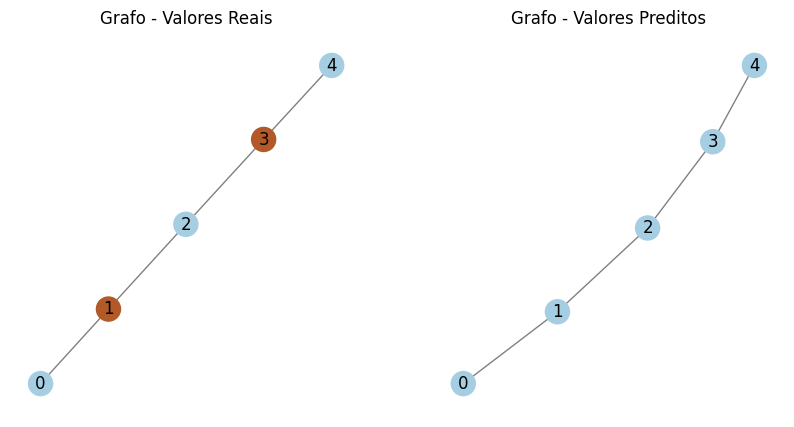

In [45]:
# plotando os grafos:

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Converte o grafo do PyTorch Geometric para um formato do NetworkX
G = to_networkx(data, to_undirected=True)

# Criando a visualização
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Criar duas imagens lado a lado

# Grafo com valores reais (y)
plt.sca(axes[0])
nx.draw(G, with_labels=True, node_color=data.y.numpy(), cmap=plt.cm.Paired, edge_color="gray")
plt.title("Grafo - Valores Reais")

# Grafo com valores previstos (y_pred)
plt.sca(axes[1])
nx.draw(G, with_labels=True, node_color=pred.numpy(), cmap=plt.cm.Paired, edge_color="gray")
plt.title("Grafo - Valores Preditos")

# Exibir
plt.show()